## Classification Bake-off:

The goal of this bake off if for students to practice the data science process and handling . Through this process, you will need to clean and prepare the data, engineer features, fit didfferent models, tune the hyperparameters of those models, and account for how any class imbalance can affect your model. 

## Data Set Information:

This dataset contains information about customers' credit card default payments in Taiwan. It was taken from a study that compares the predictive accuracy of probability of default among six data mining methods. This data set is not as clean as some of the data you have previously recieved. Below is all of the information that is given about the different columns of data. As you explore this data you will find that the 'data dictionary' below does not include all of the values that you will find in the actual dataset. You will have to make decisions on your own as to how you will interpret and handle these unknown values.  

## Evaluation:

For this bake-off, we will be scoring the submitted predictions using the F1 score. 


## Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows:
    - X6 = the repayment status in September, 2005;
    - X7 = the repayment status in August, 2005; . . .;
    - X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar).
    - X18 = amount paid in September, 2005;
    - X19 = amount paid in August, 2005; . . .;
    - X23 = amount paid in April, 2005.

# Import Data

In [87]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train_df = pd.read_csv('dataset.csv', index_col='Unnamed: 0')
train_df.shape

(22500, 24)

In [3]:
hold_df = pd.read_csv('validation_set.csv', index_col='Unnamed: 0')
hold_df.shape

(7500, 23)

# Create Features

In [4]:
# Function to rename credit limit, default, payment status, balance and payment amount columns
def rename_cols(df):
    if 'default payment next month' in df.keys():
        df = df.rename(columns={'default payment next month': 'DEFAULT'})
    df = df.rename(columns={'LIMIT_BAL': 'CREDIT_LIM'})
    df = df.rename(columns={'PAY_0': 'SEP_STS', 'PAY_2': 'AUG_STS', 'PAY_3': 'JUL_STS',
                            'PAY_4': 'JUN_STS', 'PAY_5': 'MAY_STS', 'PAY_6': 'APR_STS'})
    df = df.rename(columns={'BILL_AMT1': 'SEP_BAL', 'BILL_AMT2': 'AUG_BAL', 'BILL_AMT3': 'JUL_BAL',
                            'BILL_AMT4': 'JUN_BAL', 'BILL_AMT5': 'MAY_BAL', 'BILL_AMT6': 'APR_BAL'})
    df = df.rename(columns={'PAY_AMT1': 'SEP_PMT', 'PAY_AMT2': 'AUG_PMT', 'PAY_AMT3': 'JUL_PMT',
                            'PAY_AMT4': 'JUN_PMT', 'PAY_AMT5': 'MAY_PMT', 'PAY_AMT6': 'APR_PMT'})
    return df

In [5]:
# Function to transform extreme values
def adj_outliers(df, outlier_cols):
    for col in outlier_cols:
        std = df[col].std()
        mean = df[col].mean()
        value = mean + (5 * std)
        df[col] = df[col].apply(lambda x: value if (x>value) else x)
    return df

In [6]:
# Function to turn sex data into male dummy column
def dummies_sex(df):
    filt = df['SEX'] == 1
    df['SEX_M'] = np.where(filt, 1, 0)
    df.drop('SEX', axis=1, inplace=True)
    return df

In [7]:
# Function to turn education data into dummy columns
def dummies_edu(df):
    df['EDUCATION'] = df['EDUCATION'].map({1: 'GS', 2: 'UNI', 3: 'HS', 4: 'OTH',
                                           0: '0_UNK', 5: '5_UNK', 6: '6_UNK'})
    dummies = pd.get_dummies(df['EDUCATION'], prefix='EDU', drop_first=False)
    df = pd.concat([df, dummies], axis=1)
    df.drop(['EDUCATION', 'EDU_0_UNK'], axis=1, inplace=True)
    return df

In [8]:
# Function to turn marital status data into dummy columns
def dummies_ms(df):
    df['MARRIAGE'] = df['MARRIAGE'].map({1: 'MAR', 2: 'SGL', 3: 'DIV', 0: '0_UNK'})
    dummies = pd.get_dummies(df['MARRIAGE'], prefix='MS', drop_first=False)
    df = pd.concat([df, dummies], axis=1)
    df.drop(['MARRIAGE', 'MS_0_UNK'], axis=1, inplace=True)
    return df

In [9]:
# Function to turn payment status data into dummy columns
def dummies_sts(df):
    for m in ['SEP', 'AUG', 'JUL', 'JUN', 'MAY', 'APR']:
        df[f'{m}_PAID_BAL'] = np.where(df[f'{m}_STS'] == -1, 1, 0)
        df[f'{m}_PAID_MIN'] = np.where(df[f'{m}_STS'] == 0, 1, 0)
        df[f'{m}_DELAYED'] = np.where(df[f'{m}_STS'] > 0, 1, 0)
        df.drop(f'{m}_STS', axis=1, inplace=True)
    return df

In [10]:
# # Function to turn payment status data into dummy columns
# def dummies_sts(df):
#     for m in ['SEP', 'AUG', 'JUL', 'JUN', 'MAY', 'APR']:
#         df[f'{m}_PAID_ALL'] = np.where(df[f'{m}_STS'] == -2, 1, 0)
#         df[f'{m}_PAID_BAL'] = np.where(df[f'{m}_STS'] == -1, 1, 0)
#         df[f'{m}_PAID_MIN'] = np.where(df[f'{m}_STS'] == 0, 1, 0)
#         df[f'{m}_DEL_1'] = np.where(df[f'{m}_STS'] == 1, 1, 0)
#         df[f'{m}_DEL_2'] = np.where(df[f'{m}_STS'] == 2, 1, 0)
#         df[f'{m}_DEL_3'] = np.where(df[f'{m}_STS'] == 3, 1, 0)
#         df[f'{m}_DEL_4'] = np.where(df[f'{m}_STS'] == 4, 1, 0)
#         df[f'{m}_DEL_5'] = np.where(df[f'{m}_STS'] == 5, 1, 0)
#         df[f'{m}_DEL_6'] = np.where(df[f'{m}_STS'] == 6, 1, 0)
#         df[f'{m}_DEL_7'] = np.where(df[f'{m}_STS'] == 7, 1, 0)
#         df[f'{m}_DEL_8'] = np.where(df[f'{m}_STS'] == 8, 1, 0)
#         df[f'{m}_DEL_9'] = np.where(df[f'{m}_STS'] == 9, 1, 0)
#         df.drop([f'{m}_STS', f'{m}_PAID_ALL'], axis=1, inplace=True)
#     return df

In [11]:
# Function to calculate mean credit available and credit usage per customer
def credit_usage(df):
    copy = df.copy()
    for m in ['SEP', 'AUG', 'JUL', 'JUN', 'MAY', 'APR']:
        copy[f'{m}_CRD_AVL'] = copy['CREDIT_LIM'] - copy[f'{m}_BAL']
        copy[f'{m}_CRD_USG'] = 100 * copy[f'{m}_BAL'] / copy['CREDIT_LIM']
    df['MN_CRD_AVL'] = copy[['SEP_CRD_AVL', 'AUG_CRD_AVL', 'JUL_CRD_AVL', 'JUN_CRD_AVL',
                             'MAY_CRD_AVL', 'APR_CRD_AVL']].mean(axis=1)
    df['MN_CRD_USG'] = copy[['SEP_CRD_USG', 'AUG_CRD_USG', 'JUL_CRD_USG', 'JUN_CRD_USG',
                             'MAY_CRD_USG', 'APR_CRD_USG']].mean(axis=1)
    del copy
    return df

In [12]:
# Function to calculate mean payment as percentage of balance per customer
def payment_pct(df):
    copy = df.copy()
    for m in ['SEP', 'AUG', 'JUL', 'JUN', 'MAY', 'APR']:
        filt = copy[f'{m}_BAL'] > 0
        copy[f'{m}_PMT_PCT'] = np.where(filt, (100 * copy[f'{m}_PMT'] / copy[f'{m}_BAL']), 100)
    df['MN_PMT_PCT'] = copy[['SEP_PMT_PCT', 'AUG_PMT_PCT', 'JUL_PMT_PCT', 'JUN_PMT_PCT',
                             'MAY_PMT_PCT', 'APR_PMT_PCT']].mean(axis=1)
    del copy
    return df

In [13]:
# Function to calculate distance from and percentage of the mean credit limit
def compare_lims(df, mean_lim):
    df['LIM_DST_MN'] = df['CREDIT_LIM'] - mean_lim
    df['LIM_PCT_MN'] = 100 * df['CREDIT_LIM'] / mean_lim
    return df

# Apply Features to Dataframes

In [14]:
# Function to apply all features to dataframes
def create_features(df, outlier_cols, mean_lim):
    df = rename_cols(df)
    df = adj_outliers(df, outlier_cols)
    df = dummies_sex(df)
    df = dummies_edu(df)
    df = dummies_ms(df)
    df = dummies_sts(df)
    df = credit_usage(df)
    df = payment_pct(df)
    df = compare_lims(df, mean_lim)
    return df

# Columns containing outliers to be adjusted
outlier_cols = ['CREDIT_LIM', 'SEP_BAL', 'AUG_BAL', 'JUL_BAL', 'JUN_BAL', 'MAY_BAL', 'APR_BAL',
                'SEP_PMT', 'AUG_PMT', 'JUL_PMT', 'JUN_PMT', 'MAY_PMT', 'APR_PMT']

# Mean credit limit of combined dataframes
mean_lim = 167478

# Apply features to dataframes
train_df = create_features(train_df, outlier_cols, mean_lim)
hold_df = create_features(hold_df, outlier_cols, mean_lim)

In [15]:
# Function to drop columns where all values are 0
def drop_empties(df):
    empties = [col for col in df.loc[:, (df == 0).all(axis=0)]]
    df.drop(columns=empties, axis=1, inplace=True)
    return df

# Drop columns where all values are 0
train_df = drop_empties(train_df)
hold_df = drop_empties(hold_df)

In [16]:
# Function to add 0 values for any missing columns in two dataframes
def compare_cols(df1, df2):
    for col in df1:
        if col in df2:
            pass
        else:
            df2[col] = 0
    for col in df2:
        if col in df1:
            pass
        else:
            df1[col] = 0
    return df1, df2

# Add 0 values for any missing columns in dataframes, drop default data from holdout
train_df, hold_df = compare_cols(train_df, hold_df)
hold_df.drop('DEFAULT', axis=1, inplace=True)

In [18]:
len(train_df.keys())

48

In [19]:
len(hold_df.keys())

47

# EDA

In [20]:
# Percentage of borrowers who defaulted
dft_pct = len(train_df[train_df['DEFAULT'] == 1])/len(train_df)
dft_pct

0.2212

In [21]:
# Mean credit limit of combined dataframes
int(round(pd.concat([train_df, hold_df])['CREDIT_LIM'].mean()))

167478

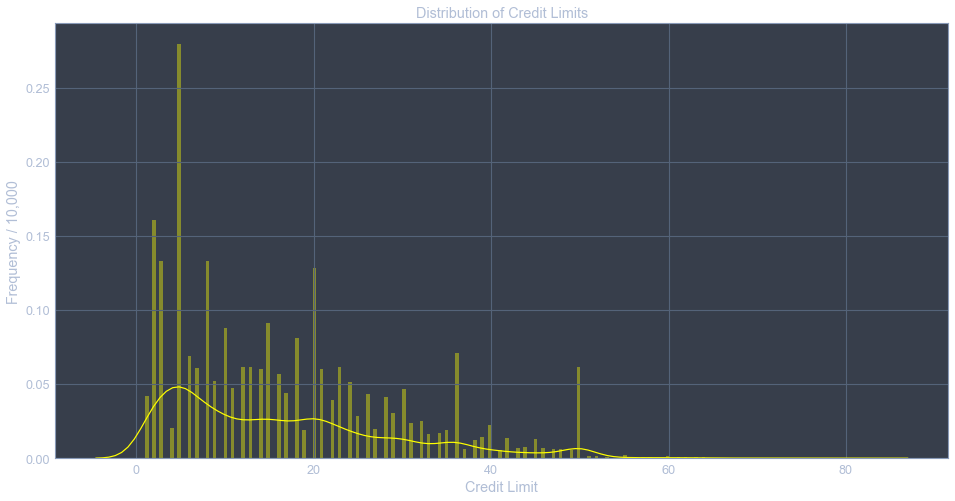

In [107]:
# Function to plot distribution of credit limits
def plot_limit_dist(df):
    plt.figure(figsize = (16,8))
    sns.distplot(df['CREDIT_LIM']/10000, bins = 200, color='yellow')
    plt.title('Distribution of Credit Limits')
    plt.xlabel('Credit Limit')
    plt.ylabel('Frequency / 10,000')
    return plt.show()

plot_limit_dist(train_df)

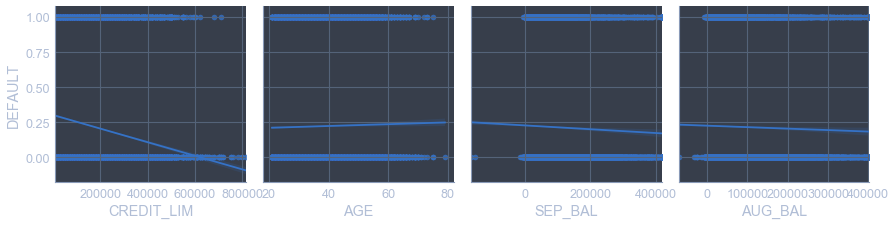

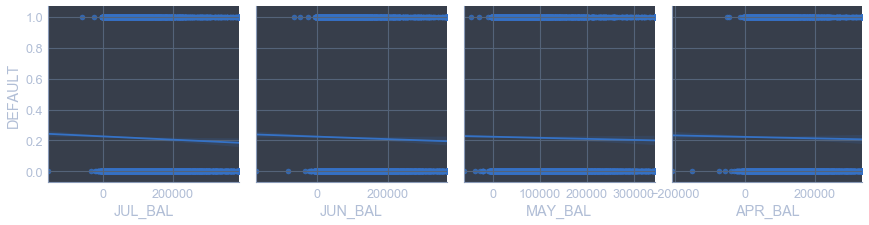

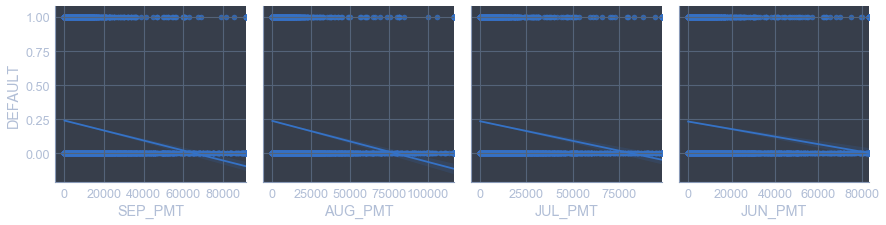

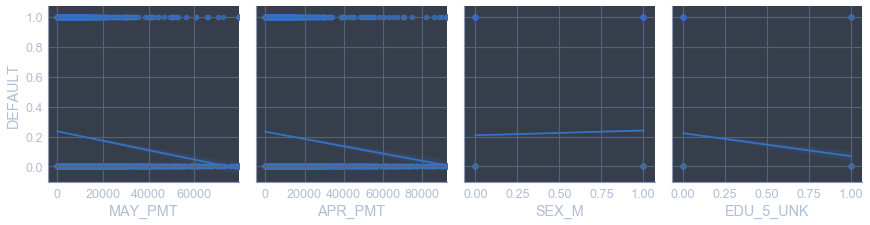

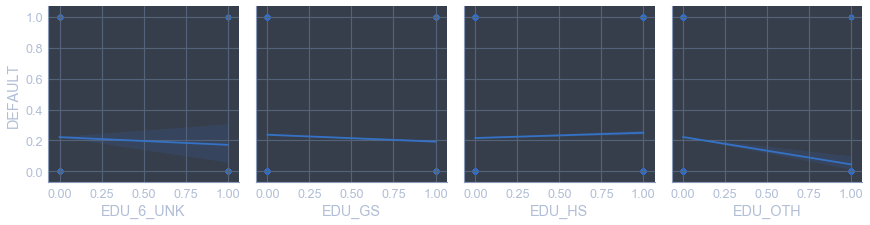

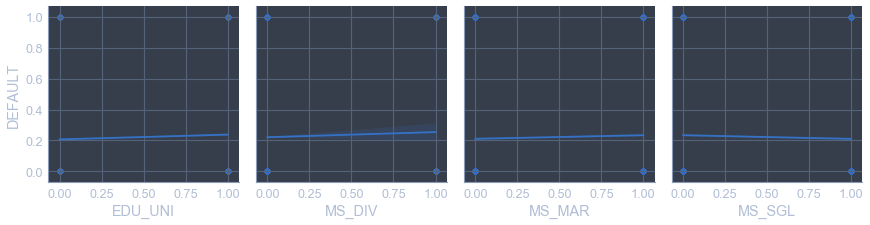

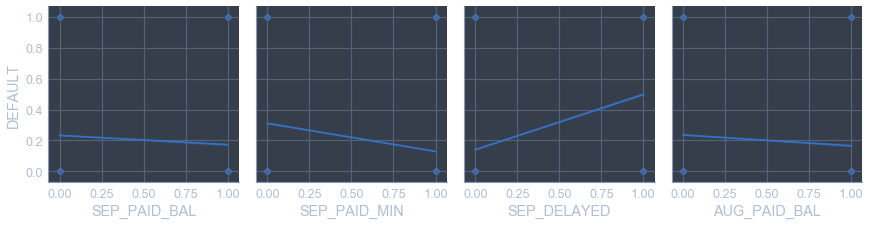

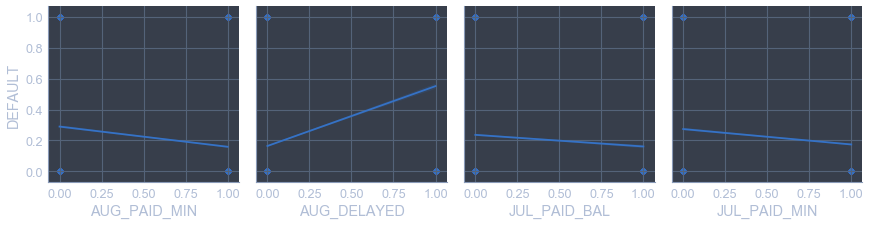

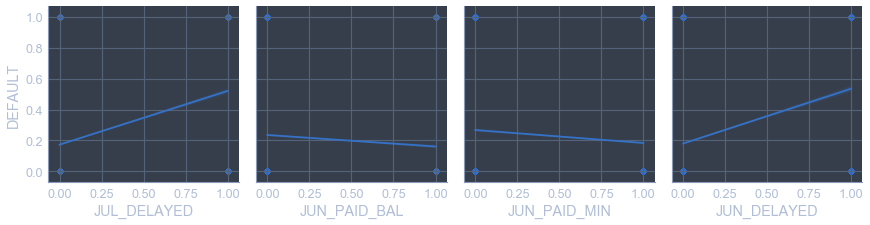

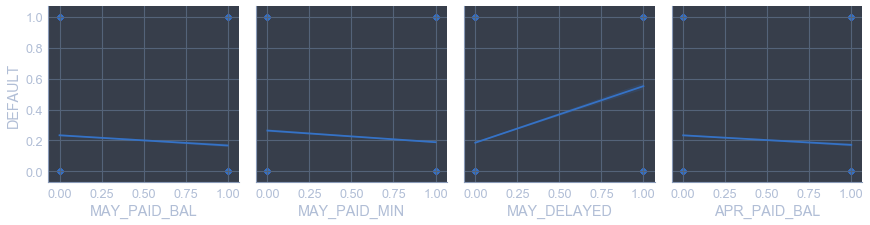

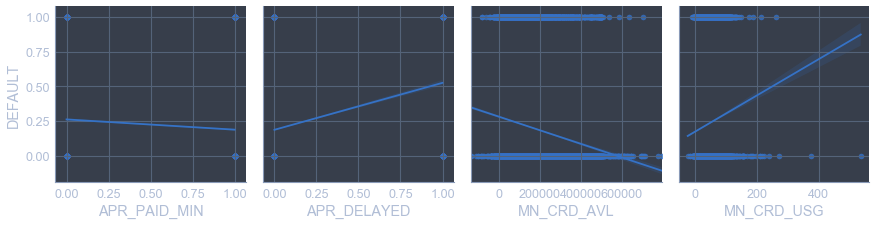

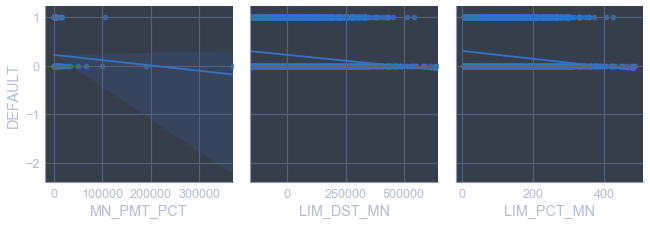

In [108]:
# Function to plot each feature vs target variable
def pplot_features(df, features):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, y_vars=['DEFAULT'], x_vars=row, kind='reg', height=3)
    return plt.show()

pplot_features(train_df, train_df.drop(columns='DEFAULT').keys())

In [109]:
# Function to create correlation matrix
def corr_matrix(df):
    corr = train_df.corr()
    return corr.style.background_gradient(cmap='coolwarm').set_precision(2)

corr_matrix(train_df)

# Train/Test Split

In [22]:
# Fucntion to split data into train and test data
def tt_split(df):
    X = df.drop('DEFAULT', axis=1)
    y = df['DEFAULT']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    return X_train, X_test, y_train, y_test

# Split training data into train and test data
X_train, X_test, y_train, y_test = tt_split(train_df)

X_train.shape, X_test.shape

((18000, 47), (4500, 47))

In [23]:
# Number of defaults in test data
pd.DataFrame(y_test)['DEFAULT'].value_counts()

0    3529
1     971
Name: DEFAULT, dtype: int64

# Standard Scalar

In [24]:
# Function to apply standard scalar
def std_sclr(df):
    scale = StandardScaler()
    trans = scale.fit_transform(df)
    return pd.DataFrame(trans, columns=df.columns)

# Scale train and holdout data
train_df_scl = std_sclr(train_df.drop('DEFAULT', axis=1))
hold_df_scl = std_sclr(hold_df)

# Scale train and test data
X_train_scl = std_sclr(X_train)
X_test_scl = std_sclr(X_test)

# SMOTE

In [28]:
# Function to perform SMOTE balancing
def smt(X_train, y_train):
    smt = SMOTE(n_jobs=-1, random_state=1)
    X_smt, y_smt = smt.fit_sample(X_train, y_train)
    return X_smt, y_smt

# Perform SMOTE balancing on train and scaled train data
X_smt, y_smt = smt(train_df.drop('DEFAULT', axis=1), train_df['DEFAULT'])
X_smt_scl, y_smt_scl = smt(train_df_scl, train_df['DEFAULT'])

# Perform SMOTE balancing on train and scaled train data
X_train_smt, y_train_smt = smt(X_train, y_train)
X_train_smt_scl, y_train_smt_scl = smt(X_train_scl, y_train)

X_smt.shape, X_train_smt.shape

((35046, 47), (27988, 47))

# Dummy Classifier

In [29]:
# Function to fit a dummy classifier model
def dmy(X_train, y_train):
    dmy = DummyClassifier()
    dmy_fit = dmy.fit(X_train, y_train)
    return dmy_fit

In [30]:
# Fit dummy classifier model on train data, predict on test data
dmy_fit = dmy(X_train, y_train)
dmy_pred = dmy_fit.predict(X_test)

# F1 score of dummy classifier predictions
f1_score(dmy_pred, y_test)

0.20383451059535823

# Logistic Regression

In [103]:
# Function to fit a logistic regression model
def lr(X_train, y_train):
    lr = LogisticRegression(C=1, penalty='l1', solver='liblinear')
    lr_fit = lr.fit(X_train, y_train)
    return lr_fit

In [104]:
# Fit logistic regression model on train data, predict on test data
lr_fit = lr(X_train, y_train)
lr_pred = lr_fit.predict(X_test)

# F1 score of logistic regression predictions
f1_score(lr_pred, y_test)

0.4178694158075601

In [105]:
# Fit logistic regression model on scaled train data, predict on scaled test data
lr_fit_scl = lr(X_train_scl, y_train)
lr_pred_scl = lr_fit_scl.predict(X_test_scl)

# F1 score of scaled logistic regression predictions
f1_score(lr_pred_scl, y_test)

0.41866849691146185

In [106]:
# Fit logistic regression model on SMOTE train data, predict on SMOTE test data
lr_fit_smt = lr(X_train_smt, y_train_smt)
lr_pred_smt = lr_fit_smt.predict(X_test)

# F1 score of scaled logistic regression predictions
f1_score(lr_pred_smt, y_test)

0.45302593659942364

In [107]:
# Fit logistic regression model on scaled SMOTE train data, predict on scaled SMOTE test data
lr_fit_smt_scl = lr(X_train_smt_scl, y_train_smt_scl)
lr_pred_smt_scl = lr_fit_smt_scl.predict(X_test)

# F1 score of scaled SMOTE logistic regression predictions
f1_score(lr_pred_smt_scl, y_test)

0.3631895139268159

# Random Forest

In [65]:
# Function to fit a random forest model
def rf(X_train, y_train):
    rf = RandomForestClassifier(n_jobs=-1, random_state=1, n_estimators=1000, oob_score=True)
    rf_fit = rf.fit(X_train, y_train)
    return rf_fit

In [66]:
# Fit random forest model on train data, predict on test data
rf_fit = rf(X_train, y_train)
rf_preds = rf_fit.predict(X_test)

# F1 score of random forest predictions
f1_score(rf_preds, y_test)

0.4428571428571429

In [94]:
# Fit random forest model on scaled train data, predict on scaled test data
rf_fit_scl = rf(X_train_scl, y_train)
rf_preds_scl = rf_fit.predict(X_test_scl)

# F1 score of scaled random forest predictions
f1_score(rf_preds_scl, y_test)

0.16234887737478412

In [70]:
# Fit random forest model on SMOTE train data, predict on SMOTE test data
rf_fit_smt = rf(X_train_smt, y_train_smt)
rf_pred_smt = rf_fit_smt.predict(X_test)

# F1 score of scaled random forest predictions
f1_score(rf_pred_smt, y_test)

0.47343565525383713

In [95]:
# Fit random forest model on scaled SMOTE train data, predict on scaled SMOTE test data
rf_fit_smt_scl = rf(X_train_smt_scl, y_train_smt_scl)
rf_pred_smt_scl = rf_fit_smt_scl.predict(X_test_scl)

# F1 score of scaled SMOTE random forest predictions
f1_score(rf_pred_smt_scl, y_test)

0.4561270801815432

# Naive Bayes

In [88]:
# Function to fit naive bayes model
def nb(X_train, y_train):
    nb = GaussianNB()
    nb_fit = nb.fit(X_train, y_train)
    return nb_fit

In [90]:
# Fit naive bayes model on train data, predict on test data
nb_fit = nb(X_train, y_train)
nb_preds = nb_fit.predict(X_test)

# F1 score of naive bayes predictions
f1_score(nb_preds, y_test)

0.3832161047780742

In [97]:
# Fit naive bayes model on scaled train data, predict on test data
nb_fit_scl = nb(X_train_scl, y_train)
nb_preds_scl = nb_fit_scl.predict(X_test_scl)

# F1 score of scaled naive bayes predictions
f1_score(nb_preds_scl, y_test)

0.48600311041990674

In [99]:
# Fit naive bayes model on SMOTE train data, predict on test data
nb_fit_smt = nb(X_train_smt, y_train_smt)
nb_preds_smt = nb_fit_smt.predict(X_test)

# F1 score of SMOTE naive bayes predictions
f1_score(nb_preds_smt, y_test)

0.37981934346772417

In [100]:
# Fit naive bayes model on scaled SMOTE train data, predict on test data
nb_fit_smt_scl = nb(X_train_smt_scl, y_train_smt_scl)
nb_preds_smt_scl = nb_fit_smt_scl.predict(X_test_scl)

# F1 score of scaled SMOTE naive bayes predictions
f1_score(nb_preds_smt_scl, y_test)

0.4197802197802198

# K Fold Random Forest

In [43]:
rf = RandomForestClassifier(n_jobs=4, random_state=0, n_estimators=100, oob_score=True)
kfold_cv = KFold(n_splits=10, shuffle=True)
rf_f1 = []

X = train_df.drop(columns=['DEFAULT'], axis=1)
y = train_df['DEFAULT']

for (train, test), i in zip(kfold_cv.split(X, y), range(10)):
    rf.fit(X.iloc[train], y.iloc[train])
    f1 = f1_score(y.iloc[test], rf.predict(X.iloc[test]))
    rf_f1.append(f1)

In [45]:
rf_f1

[0.46867167919799496,
 0.4316185696361355,
 0.4309859154929577,
 0.46938775510204084,
 0.4039829302987198,
 0.4677002583979328,
 0.43478260869565216,
 0.46731234866828086,
 0.4647713226205192,
 0.43367346938775514]

# Logistic Regression Grid Search

In [46]:
def lr_grid(X_train, y_train):
    lr = LogisticRegression(solver='liblinear', n_jobs=-1, random_state=1)
    params = {'C':[.0001, .001, .01, .1, 1, 10, 100, 1000, 10000], 'penalty':['l1', 'l2']}
    lr_grid = GridSearchCV(lr, params, cv=10, scoring='f1')
    lr_grid_fit = lr_grid.fit(X_train, y_train)
    return lr_grid_fit

In [47]:
# Fit logistic regression grid search on train data
lr_grid_fit = lr_grid(train_df.drop('DEFAULT', axis=1), train_df['DEFAULT'])

# Best logistic regression f1 score and params
lr_grid_fit.best_score_, lr_grid_fit.best_params_

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


(0.44448109116844375, {'C': 100, 'penalty': 'l1'})

In [240]:
# Fit logistic regression grid search on scaled train data
lr_grid_fit_scl = lr_grid(train_df_scl.drop('DEFAULT', axis=1), train_df_scl['DEFAULT'])

# Best scaled logistic regression f1 score and params
lr_grid_fit_scl.best_score_, lr_grid_fit_scl.best_params_

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


(0.48275781411129204, {'C': 0.0001, 'penalty': 'l2'})

In [49]:
# Fit logistic regression grid search on SMOTE train data
lr_grid_fit_smt = lr_grid(X_smt, y_smt)

# Best SMOTE logistic regression f1 score and params
lr_grid_fit_smt.best_score_, lr_grid_fit_smt.best_params_

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


(0.7943945622861959, {'C': 1, 'penalty': 'l1'})

In [50]:
# Fit logistic regression grid search on scaled SMOTE train data
lr_grid_fit_smt_scl = lr_grid(X_smt_scl, y_smt_scl)

# Best scaled SMOTE logistic regression f1 score and params
lr_grid_fit_smt_scl.best_score_, lr_grid_fit_smt_scl.best_params_

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


(0.669757834476378, {'C': 0.0001, 'penalty': 'l2'})

# Final Models

In [109]:
# Define final SMOTE logistic regression model
final_lr_smt = LogisticRegression(C=1, penalty='l1', solver='liblinear',
                                  n_jobs=-1, random_state=1)

# Define final scaled SMOTE logistic regression model
final_lr_smt_scl = LogisticRegression(C=.0001, penalty='l2', solver='liblinear',
                                      n_jobs=-1, random_state=1)

# Define final SMOTE random forest model
final_rf_smt = RandomForestClassifier(n_jobs=-1, random_state=1, n_estimators=1000)

# Define final SMOTE naive bayes model
final_nb_smt = GaussianNB()

In [60]:
# Fit final final SMOTE logistic regression model on train data, predict on test data
final_lr_smt = final_lr_smt.fit(X_train_smt, y_train_smt, final_nb_smt)
final_lr_preds_smt = final_lr_fit_smt.predict(X_test)

# F1 score of final SMOTE logistic regression model
f1_score(final_lr_preds_smt, y_test)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.45302593659942364

In [96]:
# Fit final scaled SMOTE logistic regression model on train data, predict on test data
final_lr_fit_smt_scl = final_lr_smt_scl.fit(X_train_smt_scl, y_train_smt_scl)
final_lr_preds_smt_scl = final_lr_fit_smt_scl.predict(X_test_scl)

# F1 score of final scaled SMOTE logistic regression model
f1_score(final_lr_preds_smt_scl, y_test)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.5154464663563267

In [74]:
# Fit final SMOTE random forest model on train data, predict on test data
final_rf_fit_smt = final_rf_smt.fit(X_train_smt, y_train_smt)
final_rf_preds_smt = final_rf_fit_smt.predict(X_test)

# F1 score of final SMOTE random forest model
f1_score(final_rf_preds_smt, y_test)

0.47343565525383713

# Voting Ensemble

In [115]:
# Define final voting ensemble
final_estimators = [('lr', final_lr_smt), ('rf', final_rf_smt), ('nb', final_nb_smt)]
final_ensemble = VotingClassifier(estimators=final_estimators, n_jobs=-1)

In [116]:
# Fit final voting ensemble on train data, predict on test data
final_ensemble_fit = final_ensemble.fit(X_train, y_train)
final_ensemble_preds = final_ensemble_fit.predict(X_test)

# F1 score of final voting ensemble
f1_score(final_ensemble_preds, y_test)

0.4543147208121827

In [117]:
# Fit final voting ensemble on scaled train data, predict on test data
final_ensemble_fit_scl = final_ensemble.fit(X_train_scl, y_train)
final_ensemble_preds_scl = final_ensemble_fit_scl.predict(X_test_scl)

# F1 score of scaled final voting ensemble
f1_score(final_ensemble_preds_scl, y_test)

0.4583333333333333

In [119]:
# Fit final voting ensemble on SMOTE train data, predict on test data
final_ensemble_fit_smt = final_ensemble.fit(X_train_smt, y_train_smt)
final_ensemble_preds_smt = final_ensemble_fit_smt.predict(X_test)

# F1 score of SMOTE final voting ensemble
f1_score(final_ensemble_preds_smt, y_test)

0.48209513629075357

In [120]:
# Fit final voting ensemble on scaled SMOTE train data, predict on test data
final_ensemble_fit_smt_scl = final_ensemble.fit(X_train_smt_scl, y_train_smt_scl)
final_ensemble_preds_smt_scl = final_ensemble_fit_smt_scl.predict(X_test_scl)

# F1 score of scaled SMOTE final voting ensemble
f1_score(final_ensemble_preds_smt_scl, y_test)

0.47846208615165536

# FINAL Predictions

In [131]:
# Fit final voting ensemble on SMOTE data, predict on holdout data
FINAL_fit = final_ensemble.fit(X_smt, y_smt)
FINAL_preds = pd.DataFrame(FINAL_fit.predict(hold_df))

# Final predictions
FINAL_preds[0].value_counts()

0    5920
1    1580
Name: 0, dtype: int64

In [132]:
FINAL_preds.to_csv('credit-default-preds-JEFF-ERIC.csv', header=False, index=False)